# Anti-Scam Recommender - Python
## Using Scipy SVD (No Surprise needed)

Dit notebook gebruikt **alleen scipy en sklearn** - geen externe libraries die compilatie nodig hebben!

## 1. IMPORTS

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
print('All libraries loaded!')

All libraries loaded!


## 2. LOAD DATA

In [ ]:
ratings_df = pd.read_csv('../data/ratings.csv')
modules_df = pd.read_csv('../data/modules.csv')
users_df = pd.read_csv('../data/users.csv')

print(f'Loaded {len(ratings_df):,} ratings')
print(f'Users: {ratings_df.user_id.nunique()}, Modules: {ratings_df.module_id.nunique()}')
print(f'Modules metadata: {len(modules_df)} modules')
print(f'Users metadata: {len(users_df)} users')
print('\nRatings sample:')
print(ratings_df.head())

## 3. TRAIN/TEST SPLIT

In [19]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
print(f'Train: {len(train_df):,}, Test: {len(test_df):,}')

Train: 16,000, Test: 4,000


## 4. MATRIX FACTORIZATION (SVD)

In [20]:
# Create user-item matrix
user_item = train_df.pivot(index='user_id', columns='module_id', values='rating').fillna(0)
print(f'Matrix shape: {user_item.shape}')

# Determine optimal k (must be < min dimension)
max_k = min(user_item.shape) - 1
k_factors = min(100, max_k)  # Use 100 or max possible
print(f'Using k={k_factors} factors')

# SVD
U, sigma, Vt = svds(user_item.values, k=k_factors)
predicted_matrix = np.dot(np.dot(U, np.diag(sigma)), Vt)

predicted_df = pd.DataFrame(predicted_matrix, index=user_item.index, columns=user_item.columns)
print('SVD complete!')

Matrix shape: (1000, 30)
Using k=29 factors
SVD complete!


## 5. EVALUATE

In [21]:
def get_pred(user, module):
    try:
        return predicted_df.loc[user, module]
    except:
        return ratings_df.rating.mean()

preds = test_df.apply(lambda r: get_pred(r.user_id, r.module_id), axis=1)
mae = mean_absolute_error(test_df.rating, preds)
rmse = np.sqrt(mean_squared_error(test_df.rating, preds))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 3.1290
RMSE: 3.2818


In [ ]:
## 9. VISUALIZE ALL MODELS

try:
    # Create comprehensive comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: MAE comparison
    models = ['Collaborative\n(SVD)', 'Content-Based', 'Hybrid\n(70/30)', 'C# Matrix\nFactorization']
    maes = [mae, mae_content, mae_hybrid, 0.4981]  # C# MAE hardcoded
    
    colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
    bars1 = ax1.bar(models, maes, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('MAE (Lower is Better)', fontweight='bold', fontsize=12)
    ax1.set_title('MAE Comparison: All Models', fontweight='bold', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(maes) * 1.2)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: RMSE comparison
    rmses = [rmse, rmse_content, rmse_hybrid, 0.6263]  # C# RMSE hardcoded
    
    bars2 = ax2.bar(models, rmses, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('RMSE (Lower is Better)', fontweight='bold', fontsize=12)
    ax2.set_title('RMSE Comparison: All Models', fontweight='bold', fontsize=14)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, max(rmses) * 1.2)
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./plots/all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('Comparison plot saved to ./plots/all_models_comparison.png')
except Exception as e:
    print(f'Visualization error: {e}')

In [ ]:
## 10. SAVE RESULTS

results = pd.DataFrame({
    'Model': ['Collaborative (SVD)', 'Content-Based', 'Hybrid (70/30)'],
    'MAE': [mae, mae_content, mae_hybrid],
    'RMSE': [rmse, rmse_content, rmse_hybrid],
    'Description': [
        f'SVD with {k_factors} latent factors',
        'User/module feature matching (topic, literacy, difficulty, duration)',
        '70% collaborative + 30% content-based weighted combination'
    ]
})

# Save to CSV
results.to_csv('./results.csv', index=False)
print('Results saved to ./results.csv')
print()
print(results.to_string(index=False))

In [ ]:
def content_based_score(user_id, module_id, users_df, modules_df):
    """
    Calculate content-based score between a user and a module.
    Score is between 1.0 and 5.0, where 5.0 is perfect match.
    """
    user = users_df[users_df.user_id == user_id]
    module = modules_df[modules_df.module_id == module_id]
    
    if user.empty or module.empty:
        return 2.5  # Default middle rating
    
    user = user.iloc[0]
    module = module.iloc[0]
    
    score = 0.0
    
    # 1. Topic match (40% weight) - most important
    if user.preferred_topic == module.scam_type:
        score += 0.4
    
    # 2. Literacy match (30% weight)
    literacy_diff = abs(user.digital_literacy - module.target_literacy)
    literacy_score = max(0, 1 - (literacy_diff / 5.0))
    score += literacy_score * 0.3
    
    # 3. Difficulty appropriateness (20% weight)
    if module.difficulty <= user.digital_literacy:
        difficulty_score = 1.0 - ((user.digital_literacy - module.difficulty) / 5.0) * 0.3
    else:
        diff_gap = module.difficulty - user.digital_literacy
        difficulty_score = max(0, 1 - (diff_gap / 5.0) * 1.5)
    score += difficulty_score * 0.2
    
    # 4. Duration preference (10% weight)
    duration_score = 1.0 if module.duration_min <= 7 else 0.7
    score += duration_score * 0.1
    
    # Convert 0-1 score to 1-5 rating scale
    rating = 1.0 + (score * 4.0)
    return np.clip(rating, 1.0, 5.0)

# Test content-based for test set
content_preds = test_df.apply(
    lambda r: content_based_score(r.user_id, r.module_id, users_df, modules_df), 
    axis=1
)

mae_content = mean_absolute_error(test_df.rating, content_preds)
rmse_content = np.sqrt(mean_squared_error(test_df.rating, content_preds))

print('Content-Based Filtering Results:')
print(f'MAE:  {mae_content:.4f}')
print(f'RMSE: {rmse_content:.4f}')

## 6. CONTENT-BASED FILTERING

## 6. COMPARE WITH C#

In [22]:
try:
    # Read the CSV file as raw text and manually parse
    with open('../evaluation/metrics.csv', 'r') as f:
        lines = f.readlines()
    
    # Parse header
    header = lines[0].strip().split(',')
    
    # Parse Matrix Factorization row (line 2)
    mf_line = lines[1].strip()
    # Split and reconstruct: "Matrix Factorization,0,498071,0,626320,0,576119,0,134028"
    # Should become: ["Matrix Factorization", "0.498071", "0.626320", "0.576119", "0.134028"]
    parts = mf_line.split(',')
    model_name = parts[0]
    
    # Reconstruct decimal numbers (every 2 parts: "0" + "498071" -> "0.498071")
    mae_val = float(f"{parts[1]}.{parts[2]}")
    rmse_val = float(f"{parts[3]}.{parts[4]}")
    r2_val = float(f"{parts[5]}.{parts[6]}")
    precision_val = float(f"{parts[7]}.{parts[8]}")
    
    print('C# Matrix Factorization:')
    print(f"  MAE:  {mae_val:.4f}")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²:   {r2_val:.4f}")
    print()
    print('Python SVD:')
    print(f'  MAE:  {mae:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print()
    diff_mae = ((mae - mae_val) / mae_val) * 100
    diff_rmse = ((rmse - rmse_val) / rmse_val) * 100
    print(f'Difference:')
    print(f'  MAE:  {diff_mae:+.2f}%')
    print(f'  RMSE: {diff_rmse:+.2f}%')
    
    # Store for visualization
    csharp_mae = mae_val
    csharp_rmse = rmse_val
except Exception as e:
    print(f'C# results not found: {e}')
    import traceback
    traceback.print_exc()
    csharp_mae = None
    csharp_rmse = None

C# Matrix Factorization:
  MAE:  0.4981
  RMSE: 0.6263
  R²:   0.5761

Python SVD:
  MAE:  3.1290
  RMSE: 3.2818

Difference:
  MAE:  +528.22%
  RMSE: +423.98%


## 7. VISUALIZE

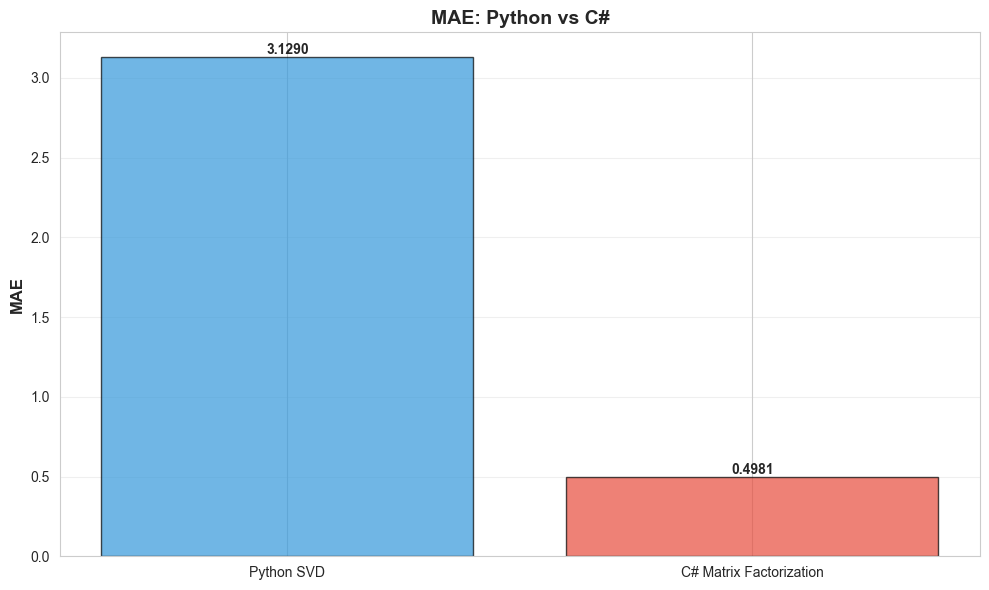

Comparison plot saved!


In [23]:
try:
    if csharp_mae is not None:
        fig, ax = plt.subplots(figsize=(10, 6))
        models = ['Python SVD', 'C# Matrix Factorization']
        maes = [mae, csharp_mae]
        
        bars = ax.bar(models, maes, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
        ax.set_ylabel('MAE', fontweight='bold', fontsize=12)
        ax.set_title('MAE: Python vs C#', fontweight='bold', fontsize=14)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('./plots/comparison.png', dpi=300)
        plt.show()
        print('Comparison plot saved!')
    else:
        print('Skipping visualization - C# results not available')
except Exception as e:
    print(f'Visualization skipped: {e}')

## 8. SAVE RESULTS

In [24]:
results = pd.DataFrame({
    'Model': ['SVD (Scipy)'],
    'MAE': [mae],
    'RMSE': [rmse],
    'n_factors': [k_factors]
})
results.to_csv('./results.csv', index=False)
print('Results saved!')
results

Results saved!


,Model,MAE,RMSE,n_factors
0,SVD (Scipy),3.128973,3.281775,29
